In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [123]:
class Galton():
    def __init__(self, n_steps, odds_right):
        self.n_steps = n_steps
        if odds_right > 1 or odds_right <0:
            print("Odds of landing on the right must be less than 1 and greater than 0")
        self.odds_right = odds_right
    
    def simulate(self, n_balls):
        """
        Simulate the Galton board
        """
        #initialize position of the balls at x=0
        pos = np.zeros(int(n_balls))

        # np.random.seed(0)
        #multiply n_steps by 2 and divide pos by 2 to avoid empty bins (only odd or only even)
        for step in range(self.n_steps*2):
            #generate a random number between 0 and 1
            r = np.random.random(int(n_balls))
            #if the random number is less than the odds of landing on the right,
            #then the ball lands on the right
            pos[r < self.odds_right] += 1
            pos[r >= self.odds_right] -= 1

        return pos/2.0


In [127]:
n_steps_big = 10
n_steps_small = 5
bins_big = np.linspace(-n_steps_big-0.5, n_steps_big+0.5, 2*n_steps_big+2)
g_big = Galton(n_steps=n_steps_big, odds_right=0.5)
bins_small = np.linspace(-n_steps_small-0.5, n_steps_small+0.5, 2*n_steps_small+2)
g_small = Galton(n_steps=n_steps_small, odds_right=0.6)

In [128]:
n_balls_big = 1.e4
n_balls_small = 1.e3
pos_big = g_big.simulate(n_balls=n_balls_big)
pos_small = g_small.simulate(n_balls=n_balls_small)

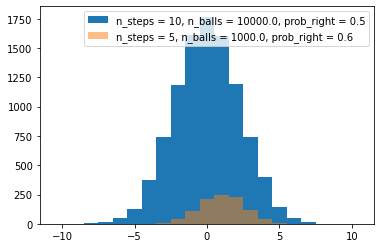

In [131]:
plt.hist(pos_big, bins=bins_big,label="n_steps = {}, n_balls = {}, prob_right = {}".format(n_steps_big, n_balls_big, g_big.odds_right))
plt.hist(pos_small, bins=bins_small,label="n_steps = {}, n_balls = {}, prob_right = {}".format(n_steps_small, n_balls_small, g_small.odds_right), alpha=0.5)
plt.legend()
plt.show()

test